In [1]:
import os
import sys
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Timing Tests with `IonPopSolver` code

For the second hot plasma paper, it would be nice to compute $T_{eff}$ for all of the EBTEL runs we are looking at so that we could compute corresponding emission measures for each of these runs with $T_{eff}$. However, the code takes a while to run. Let's look at some adjustments of the input parameters to see if we can decrease the run time.

First, we will pull out a few sample EBTEL runs and then reshape them for use with the `IonPopSolver` code.

In [ ]:
def reshape_sample(filename,two_fluid=True):
    """Reshape data from EBTEL file and save it as a tmp file"""
    tmp = np.loadtxt(filename)
    index_n = 2
    if two_fluid:
        index_n += 1 
    t,Te,n = tmp[:,0],tmp[:,1],tmp[:,index_n]
    np.savetxt(os.path.join('ebtel_data',os.path.splitext(os.path.basename(filename))[0]+'.ips_input'+'.txt'),
               np.transpose([t,Te,n]),
               header=str(len(t)),comments='',fmt='%f\t%e\t%e')

In [2]:
ebtel_file_list = ['/data/datadrive2/EBTEL_runs/electron_heating_runs/alpha2.5/data/ebtel_L40.0_tn250-b1.0_tpulse200.0_rka4/ebtel_L40.0_tn250-b1.0_tpulse200.0_rka4_0.txt',
                   '/data/datadrive2/EBTEL_runs/electron_heating_runs/alpha2.5/data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.txt'
]

In [ ]:
for ef in ebtel_file_list:
    reshape_sample(ef)

Now run the code for a couple of different options.

| `atomic_safety` | `cutoff_ion_fraction` |
| --------------- | --------------------- |
| 0. 1            | $1\times10^{-300}$    |
| 1.0             | $1\times10^{-300}$    |
| 0.1             | $1\times10^{-10}$     |
| 0.1             | $1\times10^{-6}$      |

Do a set of these for each EBTEL file (one high- and one low-frequency). The top row of the table is the baseline. We'll plot all of the results relative to the baseline and compute the resulting error.

In [3]:
#file lists for low and high frequency heating
high_freq_files=['ebtel_data/ebtel_L40.0_tn250-b1.0_tpulse200.0_rka4_0.ips_s01c300.txt',
               'ebtel_data/ebtel_L40.0_tn250-b1.0_tpulse200.0_rka4_0.ips_s10c300.txt',
                'ebtel_data/ebtel_L40.0_tn250-b1.0_tpulse200.0_rka4_0.ips_s01c10.txt',
                'ebtel_data/ebtel_L40.0_tn250-b1.0_tpulse200.0_rka4_0.ips_s01c06.txt']
low_freq_files=['ebtel_data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.ips_s01c300.txt',
               'ebtel_data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.ips_s10c300.txt',
                'ebtel_data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.ips_s01c10.txt',
                'ebtel_data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.ips_s01c06.txt']

In [4]:
labels = [r'baseline',
          r'safety=1, cutoff=$1\times10^{-300}$',
         r'safety=0.1, cutoff=$1\times10^{-10}$',
          r'safety=0.1, cutoff=$1\times10^{-6}$']

In [38]:
def plot_teff_parameters(file_list,labels,calc_error=False):
    """Make Teff diagnostic plots"""
    linestyles = ('-','--','-.',':')
    fig,axes = plt.subplots(3,1,figsize=(15,12))
    ax_error_T = axes[0].twinx()
    ax_error_Teff = axes[1].twinx()
    i=0
    for f in file_list:
        #load data
        print("loading %s"%f)
        tmp = np.loadtxt(f)
        #plot T,Teff versus t
        axes[0].plot(tmp[:,0],tmp[:,1]/1e+6,linestyle='-',color=sns.color_palette('deep')[i],
                     label=labels[i])
        axes[1].plot(tmp[:,0],tmp[:,2]/1e+6,linestyle='-',color=sns.color_palette('deep')[i])
        #plot error
        if calc_error:
            if i==0:
                tbase = tmp[:,0]
                Tbase = tmp[:,1]
                Teffbase = tmp[:,2]
                #print("interpolating...")
                #fTbase = sc.interpolate.interp1d(tbase,Tbase,kind='cubic')
                #fTeffbase = sc.interpolate.interp1d(tbase,Tbase,kind='cubic')
            else:
                #ax_error_T.plot(tmp[:,0],np.fabs(tmp[:,1]-Tbase)/Tbase,
                #               color=sns.color_palette('bright')[i],linestyle='--')
                ax_error_Teff.plot(tmp[:,0],np.fabs(tmp[:,2]-Teffbase)/Teffbase,
                               color=sns.color_palette('bright')[i],linestyle='--')
        #plot ion populations
        for j in range(np.shape(tmp[:,4:])[1]):
            axes[2].plot(tmp[:,0],tmp[:,4+j],color=sns.color_palette('deep')[i],
                        linestyle=linestyles[j%len(linestyles)])
        axes[2].set_yscale('log')
        axes[2].set_xscale('log')
        
        #increment counter
        i += 1
    #limits
    tlim0,tlim1 = 1,8e+4
    axes[0].set_xscale('log')
    axes[1].set_xscale('log')
    ax_error_T.set_xscale('log')
    ax_error_Teff.set_xscale('log')
    axes[0].set_xlim([tlim0,tlim1])
    axes[1].set_xlim([tlim0,tlim1])
    axes[2].set_xlim([tlim0,tlim1])
    ax_error_T.set_xlim([tlim0,tlim1])
    ax_error_Teff.set_xlim([tlim0,tlim1])
    axes[0].set_ylim([0,25])
    axes[1].set_ylim([0,25])
    axes[2].set_ylim([1e-6,1])
    #legend
    axes[0].legend(loc='best',fontsize=16,ncol=2)

loading ebtel_data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.ips_s01c300.txt
loading ebtel_data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.ips_s10c300.txt
loading ebtel_data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.ips_s01c10.txt
loading ebtel_data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.ips_s01c06.txt


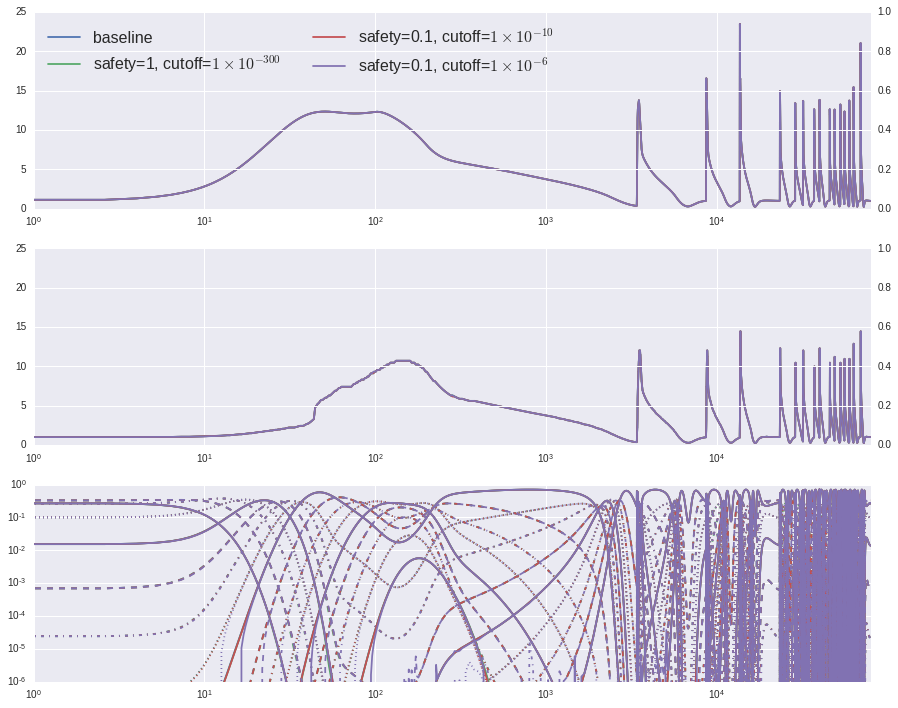

In [39]:
plot_teff_parameters(low_freq_files,labels)

loading ebtel_data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.ips_s01c300.txt
loading ebtel_data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.ips_s10c300.txt
loading ebtel_data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.ips_s01c10.txt
loading ebtel_data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.ips_s01c06.txt


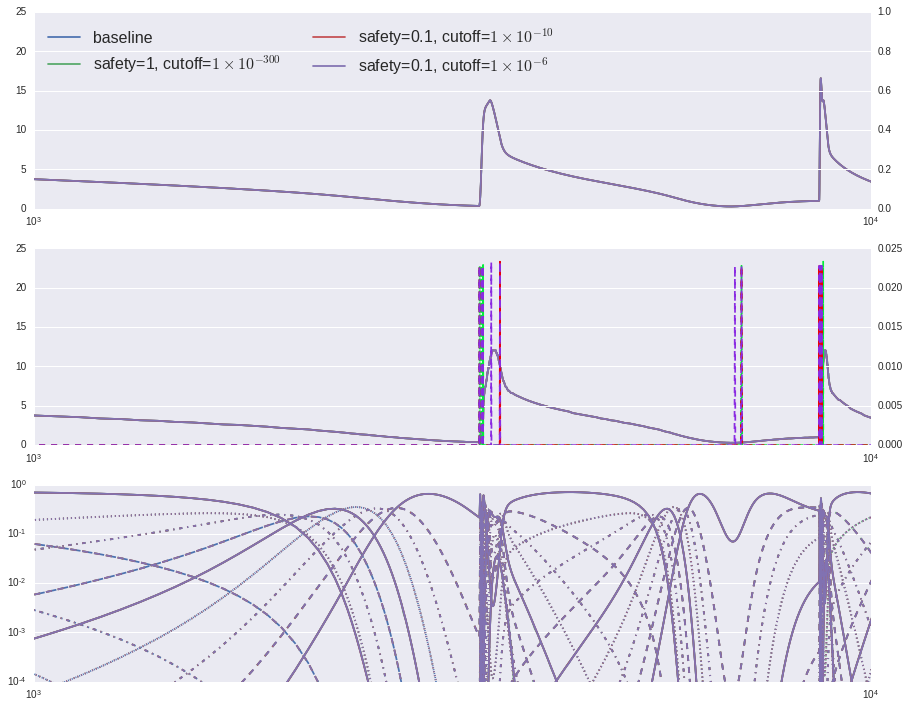

In [35]:
plot_teff_parameters(low_freq_files,labels,calc_error=True)